# Machine Learning for Champions

Let's get up to speed with the code from Data Analysis for Champions.ipynb first

In [18]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

champs = pd.read_json('data/champion-9.2.1.json')

info_types = ['attack', 'defense', 'magic', 'difficulty']
stat_types = ['hp', 'hpperlevel', 'mp', 'mpperlevel', 'movespeed', 'armor', 'armorperlevel', 'spellblock', 'spellblockperlevel', 'attackrange', 'hpregen', 'hpregenperlevel', 'mpregen', 'mpregenperlevel', 'crit', 'critperlevel', 'attackdamage', 'attackdamageperlevel', 'attackspeedperlevel', 'attackspeed']

def flatten(row):
    row = row['data']
    c = pd.Series(index=['attack', 'defense', 'magic', 'difficulty', 'tag1', 'tag2', 'partype', 'hp', 'hpperlevel', 'mp', 'mpperlevel', 'movespeed', 'armor', 'armorperlevel', 'spellblock', 'spellblockperlevel', 'attackrange', 'hpregen', 'hpregenperlevel', 'mpregen', 'mpregenperlevel', 'crit', 'critperlevel', 'attackdamage', 'attackdamageperlevel', 'attackspeedperlevel', 'attackspeed'])

    
    for info in info_types:
        c[info] = row['info'][info]
    
    if len(row['tags']) == 1:
        c['tag1'] = row['tags'][0]
    elif len(row['tags']) == 2:
        c['tag1'] = row['tags'][0]
        c['tag2'] = row['tags'][1]
    else:
        raise ValueError('More than two tags are not currently supported')
    
    c['partype'] = row['partype']
    
    for stat in stat_types:
        c[stat] = row['stats'][stat]
    
    return c

champs = champs.apply(flatten, axis=1)

max_types = ['hp', 'mp', 'armor', 'spellblock', 'hpregen', 'mpregen', 'crit', 'attackdamage', 'attackspeed']
for _stat in max_types:
    champs['max' + _stat] = champs[_stat] + champs[_stat + 'perlevel'] * 18

champs['damage'] = champs['attack'] + champs['magic']
champs['damagedefratio'] = champs['damage'] / champs['defense']
champs['challenge'] = (champs['damage'] + champs['defense']) / champs['difficulty']

def merge(df):
    if (pd.isnull(df[1])):
        return df[0]
    else:
        return df[0] + df[1]

champs['tag'] = champs[['tag1','tag2']].apply(merge, axis=1)

additional_types = ['max' + _stat for _stat in max_types] + ['damage', 'damagedefratio', 'challenge']

C:\Users\User\AppData\Local\Temp\ipykernel_16904\3674792392.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  c = pd.Series(index=['attack', 'defense', 'magic', 'difficulty', 'tag1', 'tag2', 'partype', 'hp', 'hpperlevel', 'mp', 'mpperlevel', 'movespeed', 'armor', 'armorperlevel', 'spellblock', 'spellblockperlevel', 'attackrange', 'hpregen', 'hpregenperlevel', 'mpregen', 'mpregenperlevel', 'crit', 'critperlevel', 'attackdamage', 'attackdamageperlevel', 'attackspeedperlevel', 'attackspeed'])
C:\Users\User\AppData\Local\Temp\ipykernel_16904\3674792392.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  c = pd.Series(index=['attack', 'defense', 'magic', 'difficulty', 'tag1', 'tag2', 'partype', 'hp', 'hpperlevel', 'mp', 'mpperlevel', 'movespeed', 'armor', '

In [19]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report, adjusted_rand_score, precision_score, recall_score
import pickle

X = champs[info_types + stat_types + additional_types]
y = champs['tag1']

tags_encoder = LabelEncoder()
y = pd.Series(tags_encoder.fit_transform(y), index=y.index)
labels = [tags_encoder.inverse_transform([i])[0] for i in range(6)]

partype_hotencoder = OneHotEncoder()
partype = partype_hotencoder.fit_transform(champs['partype'].values.reshape(-1,1)).toarray()
partype = pd.DataFrame(partype, columns=['partype_%d' % i for i in range(partype.shape[1])], index=X.index)
X = pd.concat([X,partype], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
X = pd.DataFrame(scaler.transform(X), index=X.index, columns=X.columns)

def new_merge(df):
    if (pd.isnull(df[1])):
        return df[0]
    else:
        if (df[0] != 'Support'):
            return df[0]
        else:
            return df[1]

#y = pd.Series(champs[['tag1', 'tag2']].apply(new_merge, axis=1), index=X.index)
#y = pd.Series(tags_encoder.transform(y), index=y.index)

#y_train = y[X_train.index]
#y_test = y[X_test.index]

# Machine Learning - Determining the best models

The plan is for the user to input these variables:
* `difficulty`, `hp`, `hpperlevel`, `mp`, `mpperlevel`, `movespeed`, `armor`, `armorperlevel`, `spellblock`, `spellblockperlevel`, `attackrange`, `hpregen`, `hpregenperlevel`, `mpregen`, `mpregenperlevel`, `crit`, `critperlevel`, `attackdamage`, `attackdamageperlevel`, `attackspeedperlevel`, `attackspeed`

While the following features will be automatically derived:
* `max(hp,hpperlevel...attackspeed)`

Which the model will use to generate, via ML, the following features:
* `attack`, `magic`, `defense` (Reason being these stats are "info" stats, aka. a summary statistic given by Riot)

Which will then derive the following features automatically:
* `damage`, `damagedefratio`, `challenge`

Let's determine the best model to use first based on all the features we have

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier

def classification_model(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
    model.fit(X_train, y_train)

    expected = y_test
    predicted = model.predict(X_test)
    
    acc_train = 0
    acc_test = 0
    precision = 0
    recall = 0
    f1 = 0
    adj_rand = 0
    
    if type(model).__name__ == 'GaussianMixture':
        adj_rand = adjusted_rand_score(expected, predicted)
    else:
        acc_train = accuracy_score(y_train, model.predict(X_train))
        acc_test = accuracy_score(expected, predicted)
        precision = precision_score(expected, predicted, average='macro')
        recall = recall_score(expected, predicted, average='macro')
        f1 = f1_score(expected, predicted, average='macro')

    kf = ShuffleSplit(n_splits=30, test_size=0.15)
    error = []
    for train, test in kf.split(X):
        kf_X_train = X.iloc[train, :]
        kf_X_test = X.iloc[test, :]
        kf_y_train = y.iloc[train]
        kf_y_test = y.iloc[test]
    
        model.fit(kf_X_train, kf_y_train)
    
        #Record error from each cross-validation run
        if type(model).__name__ == 'GaussianMixture':
            error.append(adjusted_rand_score(kf_y_test, model.predict(kf_X_test)))
        else:
            error.append(f1_score(kf_y_test, model.predict(kf_X_test), average='macro'))
        
    cross_valid_score = np.mean(error)

    return acc_train, acc_test, precision, recall, f1, adj_rand, cross_valid_score

def compare_models(models, X, y, variant=None):
    results = []
    if (variant == None):
        for model in models:
            acc_train, acc_test, precision, recall, f1, adj_rand, cv = classification_model(model, X, y)
            results.append((type(model).__name__, acc_train, acc_test, precision, recall, f1, adj_rand, cv))
        
        return pd.DataFrame(data=results, columns=['Model', 'Accuracy (Train)', 'Accuracy (Test)', 'Precision', 'Recall', 'F1 Score', 'Adj. Rand', 'Cross validation score']).sort_values(by=['Cross validation score'], ascending=False)
    else:
        for model in models:
            acc_train, acc_test, precision, recall, f1, adj_rand, cv = classification_model(model, X, y)
            results.append((variant, type(model).__name__, acc_train, acc_test, precision, recall, f1, adj_rand, cv))
        
        return pd.DataFrame(data=results, columns=['Variant', 'Model', 'Accuracy (Train)', 'Accuracy (Test)', 'Precision', 'Recall', 'F1 Score', 'Adj. Rand', 'Cross validation score']).sort_values(by=['Cross validation score'], ascending=False)


In [21]:
models = [ KNeighborsClassifier(n_neighbors=5, weights="distance")
     , GaussianNB()
     , LogisticRegression(solver='newton-cg', multi_class='multinomial')
     , DecisionTreeClassifier(min_samples_split=5)
     , SVC(gamma='auto')
     , LinearSVC()
     , RandomForestClassifier(n_estimators=20)
     , GradientBoostingClassifier()
     , GradientBoostingClassifier(n_estimators=200)
     , GaussianMixture(n_components=5,covariance_type='tied')
     , DummyClassifier()
     ]

compare_models(models, X, y, variant='Normal')

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed

,Variant,Model,Accuracy (Train),Accuracy (Test),Precision,Recall,F1 Score,Adj. Rand,Cross validation score
2,Normal,LogisticRegression,0.966942,0.727273,0.708333,0.722222,0.701984,0.000000,0.674240
0,Normal,KNeighborsClassifier,1.000000,0.772727,0.766667,0.705556,0.732997,0.000000,0.650523
8,Normal,GradientBoostingClassifier,1.000000,0.727273,0.789683,0.775794,0.777778,0.000000,0.648314
5,Normal,LinearSVC,0.991736,0.727273,0.550000,0.641667,0.589286,0.000000,0.626323
7,Normal,GradientBoostingClassifier,1.000000,0.772727,0.739394,0.750000,0.722222,0.000000,0.620624
3,Normal,DecisionTreeClassifier,0.958678,0.727273,0.822222,0.811111,0.730556,0.000000,0.614473
6,Normal,RandomForestClassifier,0.991736,0.818182,0.777778,0.800000,0.781481,0.000000,0.608635
4,Normal,SVC,0.884298,0.681818,0.651852,0.577778,0.563675,0.000000,0.582680
1,Normal,GaussianNB,0.669421,0.590909,0.625000,0.536111,0.525183,0.000000,0.399077
9,Normal,GaussianMixture,0.000000,0.000000,0.000000,0.000000,0.000000,0.216534,0.292187


From above, we can tell that logistic regression is the best model with cross-val of `0.674240`.

In [16]:
model = LogisticRegression(solver='newton-cg', multi_class='multinomial')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
model.fit(X_train, y_train)
print(classification_report(y_test, model.predict(X_test), target_names=labels))

              precision    recall  f1-score   support

    Assassin       0.33      1.00      0.50         2
     Fighter       1.00      0.60      0.75        10
        Mage       0.83      0.71      0.77         7
    Marksman       0.50      1.00      0.67         1
     Support       1.00      1.00      1.00         1
        Tank       0.00      0.00      0.00         1

    accuracy                           0.68        22
   macro avg       0.61      0.72      0.61        22
weighted avg       0.82      0.68      0.71        22



In [17]:
print(classification_report(y_train, model.predict(X_train), target_names=labels))

              precision    recall  f1-score   support

    Assassin       1.00      0.85      0.92        13
     Fighter       0.97      0.97      0.97        30
        Mage       0.93      1.00      0.96        26
    Marksman       1.00      1.00      1.00        21
     Support       1.00      0.92      0.96        13
        Tank       0.95      1.00      0.97        18

    accuracy                           0.97       121
   macro avg       0.97      0.96      0.96       121
weighted avg       0.97      0.97      0.97       121



In [7]:
print(classification_report(y, model.predict(X), target_names=labels))

              precision    recall  f1-score   support

    Assassin       1.00      0.80      0.89        15
     Fighter       0.91      0.97      0.94        40
        Mage       0.94      0.97      0.96        33
    Marksman       1.00      1.00      1.00        22
     Support       0.93      0.93      0.93        14
        Tank       0.94      0.89      0.92        19

    accuracy                           0.94       143
   macro avg       0.95      0.93      0.94       143
weighted avg       0.95      0.94      0.94       143



In [8]:
def detect_class(proba):
    threshold = 5
    return ''.join(list(proba[proba >= threshold].nlargest(2).index))

with pd.option_context('display.float_format', '{:,.5f}'.format, 'display.max_rows', None):
    y_pred = model.predict_proba(X)
    result_percent = pd.DataFrame(y_pred, index=X.index, columns=[tags_encoder.inverse_transform([i])[0] for i in range(6)]) * 100
    result_percent['Detected Type'] = result_percent.apply(detect_class, axis=1)
    result_percent['Actual Type'] = champs['tag']
    display(result_percent)

,Assassin,Fighter,Mage,Marksman,Support,Tank,Detected Type,Actual Type
Aatrox,1.16823,98.60887,0.00059,0.18085,0.00056,0.04090,Fighter,FighterTank
Ahri,1.07946,0.14645,95.25678,2.51986,0.96185,0.03559,Mage,MageAssassin
Akali,88.13895,5.68107,5.81865,0.25980,0.06149,0.04004,AssassinMage,Assassin
Alistar,0.01821,87.68659,0.04257,0.02203,0.10208,12.12851,FighterTank,TankSupport
Amumu,2.39409,0.44667,0.03588,0.00283,0.63970,96.48083,Tank,TankMage
Anivia,0.35532,0.02981,86.51847,0.20177,12.84463,0.04999,MageSupport,MageSupport
Annie,0.13415,0.00642,97.49233,1.26719,1.09718,0.00274,Mage,Mage
Ashe,0.04893,0.07239,0.43087,99.01514,0.43146,0.00122,Marksman,MarksmanSupport
AurelionSol,6.30973,0.02725,89.96165,1.56617,2.06561,0.06959,MageAssassin,MageFighter
Azir,5.48900,0.09491,93.08387,1.32691,0.00493,0.00038,MageAssassin,MageMarksman


LogisticRegression is able to detect the champion types with amazing accuracy compared to GaussianMixture, this shows that supervised learning is vastly superior to unsupervised techniques.

### Feature Importances

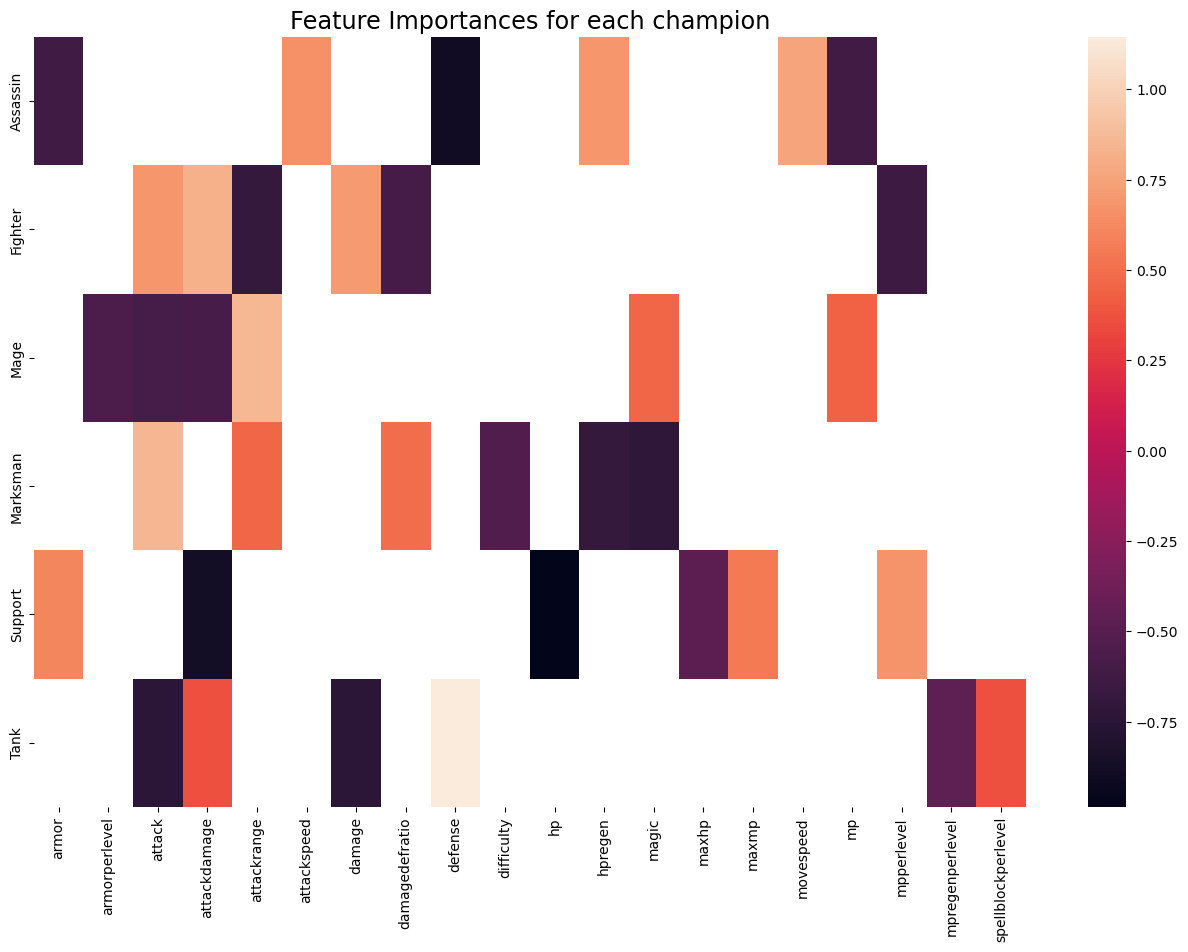

In [9]:
def importances(series):
    pos = series.nlargest(3)
    neg = series.nsmallest(3)
    return pd.concat([pos, neg])

with mpl.rc_context(rc={'figure.figsize':(16,10),'axes.titlesize':'xx-large', 'axes.xmargin': 0.01}):
    plt.title('Feature Importances for each champion')
    data = pd.DataFrame(model.coef_, index=[tags_encoder.inverse_transform([i])[0] for i in range(6)], columns=X.columns).apply(importances, axis=1)
    sns.heatmap(data = data)

Unfortunately for us, the features that won't be inputted by the user such as `attack`, `defense` and `magic` are considered important by the model. `damagedefratio`, derived from them, is also considered important by the model. Hence, if these stats aren't reliable, the accuracy of the model will suffer.